In [1]:
import os
import sys
from pathlib import  Path

import zipfile
import requests

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import  train_test_split

import tensorflow
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_probability as tfp

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer
from tensorflow.keras.layers import BatchNormalization, Input, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation, Resizing, Rescaling

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives
from tensorflow.keras.metrics import TrueNegatives, Precision, Recall, AUC, binary_accuracy

from tensorflow.keras.optimizers import Adam, RMSprop, Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1

from tensorboard.plugins.hparams import api as hp

from helper import *

In [2]:
import wandb
from wandb.keras import WandbCallback

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [4]:
d_set = tf.data.Dataset.range(10)
print(list(d_set.as_numpy_iterator()))

ll = len(list(d_set.as_numpy_iterator()))

tr_d_set = d_set.take(int(ll*0.6))
print(list(tr_d_set.as_numpy_iterator()))

val_d_set = d_set.skip(int(ll*0.6))
val_set = val_d_set.take(int(ll*0.2))
print(list(val_set.as_numpy_iterator()))

ts_d_set = val_d_set.skip(int(ll*0.2))
print(list(ts_d_set.as_numpy_iterator()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5]
[6, 7]
[8, 9]


In [5]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.2


train_dataset, val_dataset = splits(ds_train, TRAIN_RATIO, VAL_RATIO)
# print(list(train_dataset.take(1).as_numpy_iterator()),
#     list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

In [6]:
print(list(train_dataset.take(1).as_numpy_iterator()),
    list(val_dataset.take(1).as_numpy_iterator()))

[(array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
    

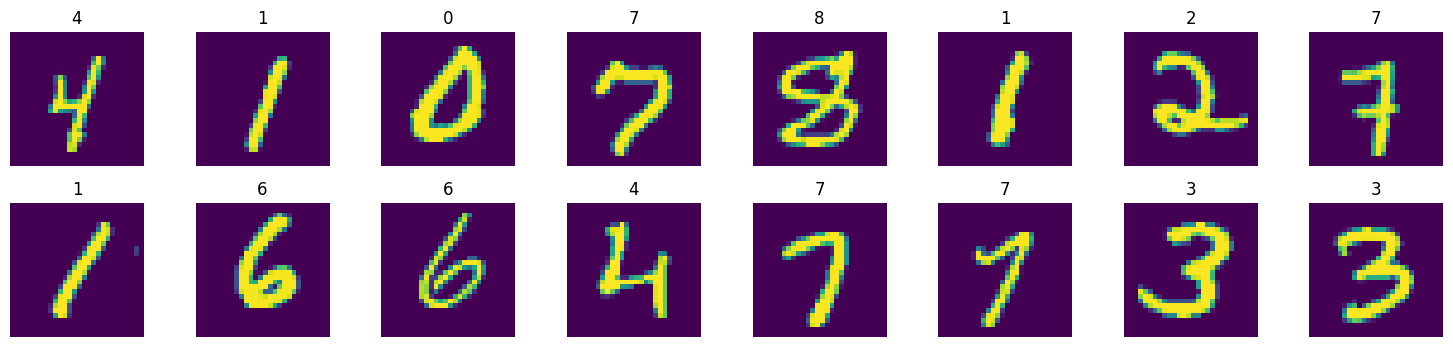

In [7]:
plt.figure(figsize=(15,7))
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 8, i + 1)

  plt.imshow(image)
  plt.title(ds_info.features['label'].int2str(label.numpy()))
  plt.axis('off')
plt.tight_layout()
plt.show()

In [135]:
CONFIGURATION = {
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 5,
    "BATCH_SIZE": 128,
    "DROPOUT_RATE": 0.0,
    "IM_SIZE": 24,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
}
IM_SIZE =24

In [319]:
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE)) / 255., label


def augment_0(image, label):
  image, label = resize_rescale(image, label)

  return image, label

def augment_1(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.random_brightness(image, 0.2)
  return image, label


def augment_2(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.random_flip_up_down(image)
  return image, label


def augment_3(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.flip_left_right(image)
  return image, label


def augment_4(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.rot90(image)
  return image, label


def augment_5(image, label):
  image, label = resize_rescale(image, label)

  return image, label

In [320]:
def visualize(original_image, Augmented_image):
  plt.subplot(1, 2, 1)
  plt.imshow(original_image)

  plt.subplot(1, 2, 2)
  plt.imshow(Augmented_image)
  plt.tight_layout()
  plt.show()

In [321]:
original_image, label = next(iter(train_dataset))

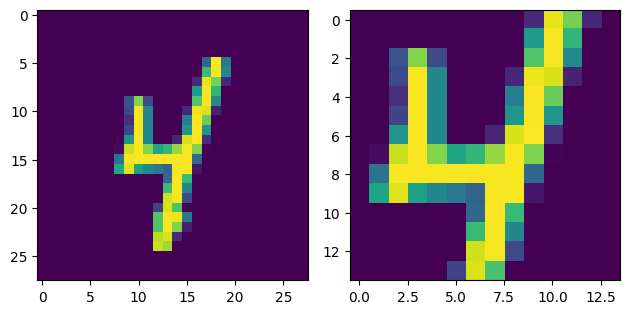

In [322]:
Augmented_image = tf.image.rot90(original_image, k=1, name=None)
Augmented_image = tf.image.flip_left_right(original_image)
Augmented_image = tf.image.adjust_brightness(original_image, delta=0.8)
Augmented_image = tf.image.adjust_contrast(original_image, contrast_factor=19)
Augmented_image = tf.image.random_flip_up_down(original_image)
Augmented_image = tf.image.rot90(original_image, k=2)

# Convert grayscale images to RGB
rgb_images = tf.image.grayscale_to_rgb(original_image)
Augmented_image = tf.image.random_saturation(rgb_images, lower=2, upper=12)
Augmented_image = tf.image.adjust_saturation(
    rgb_images, saturation_factor=0.9, name=None)
Augmented_image = tf.image.random_brightness(
    rgb_images, max_delta=0.1, seed=None)
Augmented_image = tf.image.adjust_gamma(original_image, gamma=0.1, gain=0.1)


Augmented_image = tf.image.central_crop(original_image, central_fraction=0.5)

visualize(original_image, Augmented_image)

In [323]:
train_dataset_0 = (
        train_dataset
        .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
        .map(augment_0)
    )
val_dataset_0 = (
    val_dataset
        .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
        .map(augment_0)
    )
train_dataset_1 = (
        train_dataset
        .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
        .map(augment_1)
    )
val_dataset_1 = (
    val_dataset
        .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
        .map(augment_1)
    )
train_dataset_2 = (
        train_dataset
        .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
        .map(augment_2)
    )
val_dataset_2 = (
    val_dataset
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .map(augment_2)
)
train_dataset_3 = (
        train_dataset
        .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
        .map(augment_3)
    )
val_dataset_3 = (
    val_dataset
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .map(augment_3)
)
train_dataset_4 = (
        train_dataset
        .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
        .map(augment_4)
    )
val_dataset_4 = (
    val_dataset
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .map(augment_4)
)
train_dataset_5 = (
        train_dataset
        .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
        .map(augment_5)
    )
val_dataset_5 = (
    val_dataset
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .map(augment_5)
)

In [326]:
full_train_dataset = train_dataset_0.concatenate(train_dataset_1).concatenate(train_dataset_2).concatenate(
    train_dataset_3).concatenate(train_dataset_4).concatenate(train_dataset_5)
full_val_dataset = val_dataset_0.concatenate(val_dataset_1).concatenate(val_dataset_2).concatenate(
    val_dataset_3).concatenate(val_dataset_4).concatenate(val_dataset_5)

In [327]:
full_train_data = (
    full_train_dataset
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(128)
    .prefetch(tf.data.AUTOTUNE)
)
full_val_data = (
    full_val_dataset
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(128)
    .prefetch(tf.data.AUTOTUNE)
)

In [328]:
test_ = ds_test.map(resize_rescale)
# test_data = test_.shuffle(
#     buffer_size=8, reshuffle_each_iteration=True).batch(128).prefetch(tf.data.AUTOTUNE)

In [329]:
im, lab = next(iter(full_train_data.take(1)))

In [330]:
for image, label in full_train_data.take(1):
    print(image)

tf.Tensor(
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0

In [331]:
test_data = test_.batch(1)

In [332]:
class FeatureExtractor(Layer):
    def __init__(self,filters,kernel_size,strides,padding,activation,pool_size):
        super(FeatureExtractor,self).__init__()
        
        self.conv_1 = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_1 = tf.keras.layers.BatchNormalization()
        self.maxpool_1 = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=strides*2, padding=padding)
        
        self.conv_2 = tf.keras.layers.Conv2D(filters=filters*2+4, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_2 = tf.keras.layers.BatchNormalization()
        self.maxpool_2 = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=strides*2, padding=padding)
        
    def call(self,x, training):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.maxpool_1(x)
        
        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.maxpool_2(x)
        
        return x
    

class ModelExtractor(Model):
    def __init__(self):
        super(ModelExtractor, self).__init__()

        self.fetaure_extractor = FeatureExtractor(filters=6,
                                       kernel_size=5,
                                       strides=1,
                                       padding='valid',
                                       activation='relu',
                                       pool_size=2)
        
        self.flatten = tf.keras.layers.Flatten()

        self.dense_1 = tf.keras.layers.Dense(120, activation='relu')
        self.batch_1 = tf.keras.layers.BatchNormalization()
        self.dense_2 = tf.keras.layers.Dense(84, activation='relu')
        self.batch_2 = tf.keras.layers.BatchNormalization()
        self.dense_3 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x, training):
        x = self.fetaure_extractor(x)
        x = self.flatten(x)
        
        x = self.dense_1(x)
        x = self.batch_1(x)
        
        x = self.dense_2(x)
        x = self.batch_2(x)

        x = self.dense_3(x)

        return x
    
feature_sub_classed = FeatureExtractor(filters=6,
                                       kernel_size=5,
                                       strides=1,
                                       padding='valid',
                                       activation='relu',
                                       pool_size=2)

model_sub_classed = ModelExtractor()

In [333]:
func_input = Input(shape=(24, 24, 1), name="Input Image")


x = feature_sub_classed(func_input)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(120, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(84, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
func_output = tf.keras.layers.Dense(10, activation='softmax')(x)


lenet_model_subclass = Model(
    func_input, func_output, name="Lenet_Model_Subclass")

lenet_model_subclass.summary()

Model: "Lenet_Model_Subclass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 24, 24, 1)]       0         
                                                                 
 feature_extractor_8 (Featu  (None, 3, 3, 16)          2660      
 reExtractor)                                                    
                                                                 
 flatten_10 (Flatten)        (None, 144)               0         
                                                                 
 dense_30 (Dense)            (None, 120)               17400     
                                                                 
 batch_normalization_42 (Ba  (None, 120)               480       
 tchNormalization)                                               
                                                                 
 dense_31 (Dense)            (None, 84)       

In [334]:
func_input = Input(shape=(24, 24, 1), name="Input Image")

func_output = model_sub_classed(func_input)

lenet_model_sub_classed = Model(func_input, func_output, name="Lenet_Model_sub_classed")

lenet_model_sub_classed.summary()

Model: "Lenet_Model_sub_classed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 24, 24, 1)]       0         
                                                                 
 model_extractor_4 (ModelEx  (None, 10)                31890     
 tractor)                                                        
                                                                 
Total params: 31890 (124.57 KB)
Trainable params: 31438 (122.80 KB)
Non-trainable params: 452 (1.77 KB)
_________________________________________________________________


In [337]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if (logs.get('val_sparse_categorical_accuracy')>=0.992):
            print("99.5% Accuracy is reached .......Hence Stopping")
            self.model.stop_training=True  
                                                                                   
def schedule_func(epoch,lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Giving call back for accuracy
callbacks = CustomCallback() 

# Giving call back for EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=15,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
      
# Logging the losses and metrics data
filename = 'log.csv'
csv_logger = tf.keras.callbacks.CSVLogger(filename, separator=',', append=False)

# Changing Learning Rate with a Scheduler function
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule_func)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_sparse_categorical_accuracy',
                                                    factor=0.1,
                                                    patience=2,
                                                    verbose=1,
                                                    mode='auto',
                                                    min_delta=0.0001,
                                                    min_lr=0.0000001
                                                )

# Saving the best model and its weights to given path
checkpoint_filepath = 'weights/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                                    filepath=checkpoint_filepath,
                                                                    verbose = 1,
                                                                    save_weights_only=True,
                                                                    save_best_only=True,
                                                                    monitor='val_loss',
                                                                    mode='auto'
                                                                    )

In [338]:
lenet_model_sub_classed.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                                metrics=['sparse_categorical_accuracy'])

lenet_history = lenet_model_sub_classed.fit(full_train_data,
                                            validation_data=full_val_data,
                                            epochs=50,
                                            verbose=2,
                                            callbacks = [callbacks, 
                                                        early_stopping, 
                                                        csv_logger, 
                                                        lr_scheduler, 
                                                        model_checkpoint_callback])

Epoch 1/50

Epoch 1: val_loss improved from inf to 0.37475, saving model to weights/tmp\checkpoint
2250/2250 - 45s - loss: 0.0283 - sparse_categorical_accuracy: 0.9912 - val_loss: 0.3747 - val_sparse_categorical_accuracy: 0.9164 - lr: 0.0100 - 45s/epoch - 20ms/step
Epoch 2/50

Epoch 2: val_loss did not improve from 0.37475
2250/2250 - 45s - loss: 0.0261 - sparse_categorical_accuracy: 0.9918 - val_loss: 0.4447 - val_sparse_categorical_accuracy: 0.9048 - lr: 0.0100 - 45s/epoch - 20ms/step
Epoch 3/50

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 3: val_loss did not improve from 0.37475
2250/2250 - 39s - loss: 0.0264 - sparse_categorical_accuracy: 0.9920 - val_loss: 0.3882 - val_sparse_categorical_accuracy: 0.9080 - lr: 0.0100 - 39s/epoch - 18ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.37475 to 0.19919, saving model to weights/tmp\checkpoint
2250/2250 - 42s - loss: 0.0387 - sparse_categorical_accuracy: 0.9879 - val_loss: 0.1992 - val_sparse_c

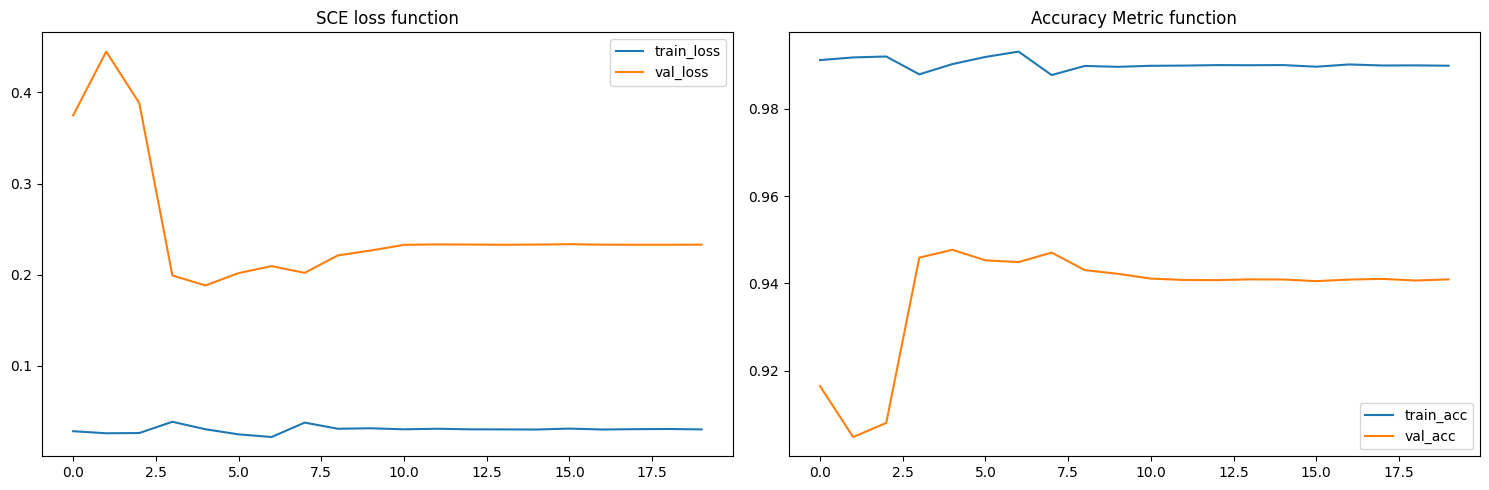

In [339]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(lenet_history.history['loss'], label="train_loss")
ax[0].plot(lenet_history.history['val_loss'], label="val_loss")
ax[0].set_title("SCE loss function")
ax[0].legend()

ax[1].plot(lenet_history.history['sparse_categorical_accuracy'],
           label="train_acc")
ax[1].plot(lenet_history.history['val_sparse_categorical_accuracy'],
           label="val_acc")
ax[1].set_title("Accuracy Metric function")
ax[1].legend()
plt.tight_layout()
plt.show()

In [340]:
lenet_model_sub_classed.evaluate(test_data)

10000/10000 [==============================] - 25s 2ms/step - loss: 0.0414 - sparse_categorical_accuracy: 0.9896


[0.04140853509306908, 0.9896000027656555]

1/1 [==============================] - 0s 37ms/step


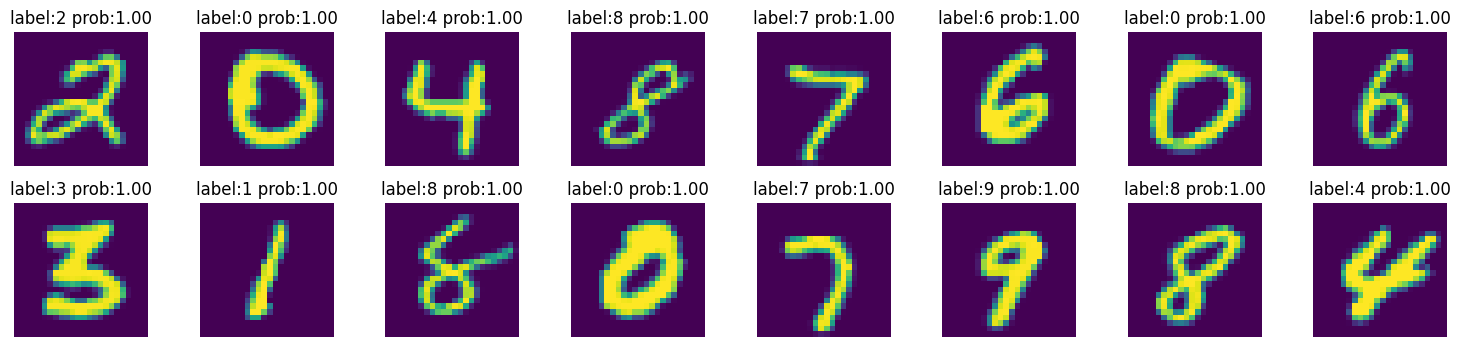

In [341]:
plt.figure(figsize=(15, 7))

for i, (image, label) in enumerate(test_data.take(16)):

  ax = plt.subplot(4, 8, i + 1)

  plt.imshow(tf.squeeze(image, axis=0))

  pred_prob_lst = lenet_model_sub_classed.predict(image)

  pred_label = np.argmax(pred_prob_lst)

  pred_prob = np.max(pred_prob_lst)

  plt.title(f"label:{pred_label} prob:{pred_prob:.2f}")
  plt.axis('off')
plt.tight_layout()

plt.show()

In [109]:
lenet_model_sub_classed.save_weights('weights/lenet_weights')
lenet_model_sub_classed.load_weights('weights/lenet_weights')
lenet_model_sub_classed.evaluate(test_data)

In [111]:
lenet_model_sub_classed.load_weights(checkpoint_filepath)
lenet_model_sub_classed.evaluate(test_data)

10000/10000 [==============================] - 29s 3ms/step - loss: 0.0596 - sparse_categorical_accuracy: 0.9888


[0.05957506597042084, 0.9887999892234802]